# 评估模型的性能并调参

#### 运行环境：  
* pandas==1.1.5
* numpy==1.16.5
* matplotlib==3.3.4
* scikit-learn==0.24.1

In [8]:
# 加载基本工具库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import warnings
warnings.filterwarnings("ignore")

In [9]:
# 加载数据
df = pd.read_csv("./wdbc.data",header=None)
# 做基本的数据预处理
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:,2:].values
y = df.iloc[:,1].values
le = LabelEncoder()    #将M-B等字符串编码成计算机能识别的0-1
y = le.fit_transform(y)
le.transform(['M','B'])
# 数据切分8：2
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

In [10]:
'''
方式1：make_pipeline
把所有的操作全部封在一个管道pipeline内形成一个工作流：
标准化+PCA+逻辑回归
'''

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr1 = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1))
pipe_lr1.fit(X_train,y_train)
y_pred1 = pipe_lr1.predict(X_test)
print("Test Accuracy: %.3f"% pipe_lr1.score(X_test,y_test))


Test Accuracy: 0.956


In [11]:
'''
方式2：Pipeline
把所有的操作全部封在一个管道pipeline内形成一个工作流：
标准化+PCA+逻辑回归
'''
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr2 = Pipeline([['std',StandardScaler()],['pca',PCA(n_components=2)],['lr',LogisticRegression(random_state=1)]])
pipe_lr2.fit(X_train,y_train)
y_pred2 = pipe_lr2.predict(X_test)
print("Test Accuracy: %.3f"% pipe_lr2.score(X_test,y_test))


Test Accuracy: 0.956


## 使用k折交叉验证评估模型性能

In [12]:
# 评估方式1：k折交叉验证

from sklearn.model_selection import cross_val_score

scores1 = cross_val_score(estimator=pipe_lr1,X = X_train,y = y_train,cv=10,n_jobs=1)
print("CV accuracy scores:%s" % scores1)
print("CV accuracy:%.3f +/-%.3f"%(np.mean(scores1),np.std(scores1)))

CV accuracy scores:[0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy:0.950 +/-0.014


In [13]:
# 评估方式2：分层k折交叉验证

from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10,random_state=1,shuffle=True).split(X_train,y_train)
scores2 = []
for k,(train,test) in enumerate(kfold):
    pipe_lr1.fit(X_train[train],y_train[train])
    score = pipe_lr1.score(X_train[test],y_train[test])
    scores2.append(score)
    print('Fold:%2d,Class dist.:%s,Acc:%.3f'%(k+1,np.bincount(y_train[train]),score))
print('\nCV accuracy :%.3f +/-%.3f'%(np.mean(scores2),np.std(scores2)))

Fold: 1,Class dist.:[256 153],Acc:0.913
Fold: 2,Class dist.:[256 153],Acc:1.000
Fold: 3,Class dist.:[256 153],Acc:0.957
Fold: 4,Class dist.:[256 153],Acc:0.978
Fold: 5,Class dist.:[256 153],Acc:0.891
Fold: 6,Class dist.:[257 153],Acc:0.933
Fold: 7,Class dist.:[257 153],Acc:0.933
Fold: 8,Class dist.:[257 153],Acc:0.978
Fold: 9,Class dist.:[257 153],Acc:0.978
Fold:10,Class dist.:[257 153],Acc:0.911

CV accuracy :0.947 +/-0.034


## 使用学习和验证曲线调试算法

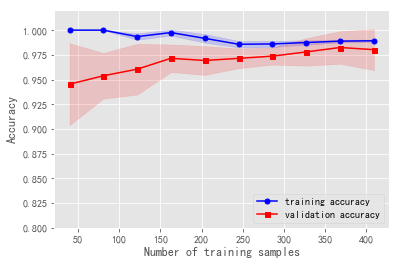

In [14]:
# 用学习曲线诊断偏差与方差
from sklearn.model_selection import learning_curve

pipe_lr3 = make_pipeline(StandardScaler(),LogisticRegression(random_state=1,penalty='l2'))
train_sizes,train_scores,test_scores = learning_curve(estimator=pipe_lr3,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1,10),cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)
plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
plt.plot(train_sizes,test_mean,color='red',marker='s',markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='red')
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.ylim([0.8,1.02])
plt.show()

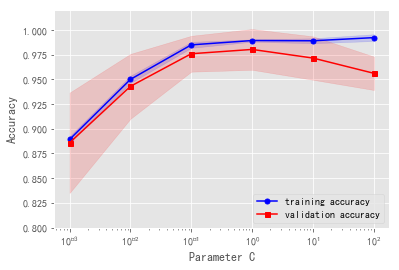

In [15]:
# 用验证曲线解决欠拟合和过拟合
from sklearn.model_selection import validation_curve

pipe_lr3 = make_pipeline(StandardScaler(),LogisticRegression(random_state=1,penalty='l2'))
param_range = [0.001,0.01,0.1,1.0,10.0,100.0]
train_scores,test_scores = validation_curve(estimator=pipe_lr3,X=X_train,y=y_train,param_name='logisticregression__C',param_range=param_range,cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)
plt.plot(param_range,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
plt.plot(param_range,test_mean,color='red',marker='s',markersize=5,label='validation accuracy')
plt.fill_between(param_range,test_mean+test_std,test_mean-test_std,alpha=0.15,color='red')
plt.xscale('log')
plt.xlabel("Parameter C")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.ylim([0.8,1.02])
plt.show()

## 通过网格搜索进行超参数调优

In [16]:
# 方式1：网格搜索GridSearchCV()
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

start_time = time.time()
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy',cv=10,n_jobs=-1)
gs = gs.fit(X_train,y_train)
end_time = time.time()
print("网格搜索经历时间：%.3f S" % float(end_time-start_time))
print(gs.best_score_)
print(gs.best_params_)

网格搜索经历时间：2.922 S
0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [17]:
# 方式2：随机网格搜索RandomizedSearchCV()
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import time

start_time = time.time()
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]
# param_grid = [{'svc__C':param_range,'svc__kernel':['linear','rbf'],'svc__gamma':param_range}]
gs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=param_grid,scoring='accuracy',cv=10,n_jobs=-1)
gs = gs.fit(X_train,y_train)
end_time = time.time()
print("随机网格搜索经历时间：%.3f S" % float(end_time-start_time))
print(gs.best_score_)
print(gs.best_params_)

随机网格搜索经历时间：0.315 S
0.9824154589371981
{'svc__kernel': 'rbf', 'svc__gamma': 0.01, 'svc__C': 10.0}


In [18]:
# 方式3：嵌套交叉验证
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import time

start_time = time.time()
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,scoring='accuracy',cv=2,n_jobs=-1)
scores = cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)
end_time = time.time()
print("嵌套交叉验证：%.3f S" % float(end_time-start_time))
print('CV accuracy :%.3f +/-%.3f'%(np.mean(scores),np.std(scores)))

嵌套交叉验证：1.451 S
CV accuracy :0.974 +/-0.015


## 比较不同的性能评估指标

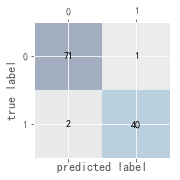

In [19]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test,y_pred=y_pred)
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [20]:
# 各种指标的计算
from sklearn.metrics import precision_score,recall_score,f1_score

print('Precision:%.3f'%precision_score(y_true=y_test,y_pred=y_pred))
print('recall_score:%.3f'%recall_score(y_true=y_test,y_pred=y_pred))
print('f1_score:%.3f'%f1_score(y_true=y_test,y_pred=y_pred))

Precision:0.976
recall_score:0.952
f1_score:0.964


In [21]:
# 将不同的指标与GridSearch结合
from sklearn.metrics import make_scorer,f1_score
scorer = make_scorer(f1_score,pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring=scorer,cv=10)
gs = gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9880771478667446
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


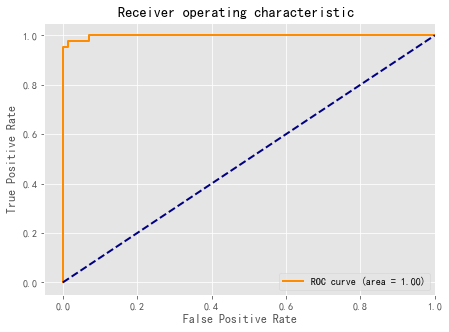

In [22]:
# 绘制ROC曲线
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import make_scorer,f1_score
scorer = make_scorer(f1_score,pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring=scorer,cv=10)
y_pred = gs.fit(X_train,y_train).decision_function(X_test)
#y_pred = gs.predict(X_test)
fpr,tpr,threshold = roc_curve(y_test, y_pred) ###计算真阳率和假阳率
roc_auc = auc(fpr,tpr) ###计算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假阳率为横坐标，真阳率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()

## 基于SVM的人脸识别
参照：https://blog.csdn.net/cwlseu/article/details/52356665

In [23]:
#数据处理
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X_lfw = lfw_people.data
y_lfw = lfw_people.target

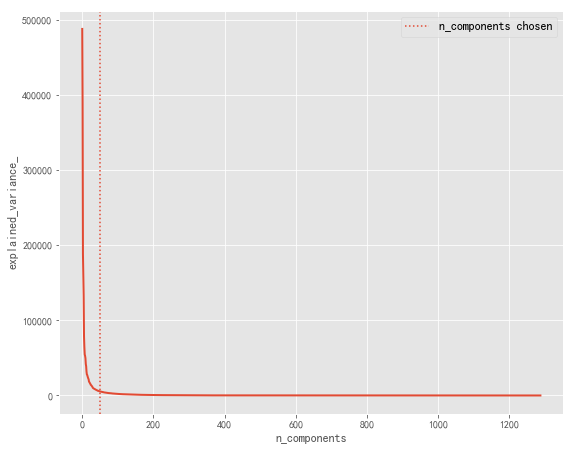

In [24]:
###############################################################################
# Plot the PCA spectrum
pca.fit(X_lfw)

plt.figure(1, figsize=(10, 8))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

###############################################################################
# Prediction

n_components = [10, 20, 25, 30, 35, 40, 50, 64]#[i for i in range(1,65)]#
Cs = np.logspace(-4, 4, 3)

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_lfw, y_lfw)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 80 eigenfaces from 966 faces
done in 1.300s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.016s
Fitting the classifier to the training set
done in 21.313s
Best estimator found by grid search:
SVC(C=1, class_weight='balanced', gamma=0.01)
[ 61 166  90 355  83  54 102]
Predicting people's names on the test set
done in 0.031s
                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.69      0.75        13
     Colin Powell       0.84      0.90      0.87        60
  Donald Rumsfeld       0.77      0.63      0.69        27
    George W Bush       0.92      0.96      0.94       146
Gerhard Schroeder       0.66      0.76      0.70        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.88      0.78      0.82        36

         accuracy                           0.86       322
        macro avg       0.81    

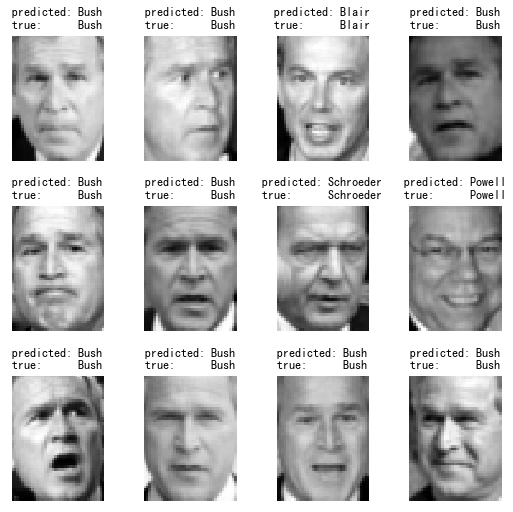

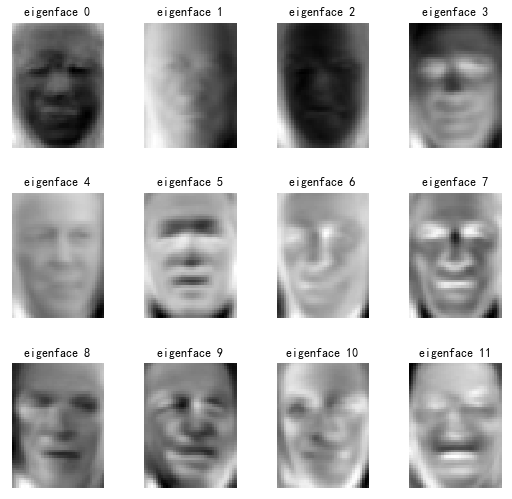

In [25]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 80

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1,10, 100, 500, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

print(clf.best_estimator_.n_support_)
###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        # Show the feature face
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

# SVM应用——人脸识别
引用:https://blog.csdn.net/jasonzhoujx/article/details/81905923

In [26]:
#下载数据
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


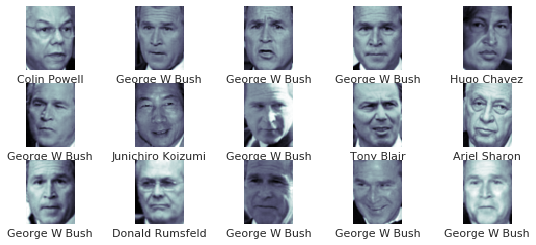

In [27]:
#画一些人脸，看看需要处理的数据
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
fig, ax = plt.subplots(3,5)
fig.subplots_adjust(left=0.0625, right=1.2, wspace=1)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

In [28]:
#使用预处理来提取更有意义的特征。这里使用主成份分析来提取150个基本元素，然后将其提供给支持向量机分类器。
#将这个预处理和分类器打包成管道

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

#为了测试分类器的训练效果，将数据集分解成训练集和测试集进行交叉检验
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(faces.data, faces.target, random_state=42)


#使用GraidSearchCV
#用网络搜索交叉检验来寻找最优参数组合。通过不断调整C（松弛变量）和参数gamma（控制径向基函数核的大小），确定最优模型
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
param_grid = {'svc__C': [1,5,10,50], 'svc__gamma':[0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid,n_jobs=-1,scoring = 'accuracy') 
'''
GridSearchCV参数说明:
model：设置训练的学习器
param_dist：字典类型，放入参数搜索范围
n_jobs = -1，使用所有的CPU进行训练，默认为1，使用1个CPU。-1代表使用当前所有的核
scoring = 'neg_log_loss'：精度评价方式设定为“accuracy“
scoring参数说明（默认：None）:
分类情况:
accuracy,average_precision,f1,f1_micro,f1_macro,f1_weighted,f1_samples,neg_log_loss,precision,recall,roc_auc
回归情况：
neg_mean_absolute_error,neg_mean_squared_error,neg_median_absolute_error,r2
'''

#使用RandomizedSearchCV
#以随机在参数空间中采样的方式代替了GridSearchCV对于参数的网格搜索,参数说明同GridSearchCV
rand = RandomizedSearchCV(model, param_grid,n_jobs=-1,scoring = 'accuracy')

#查看GraidSearchCV的结果
grid.fit(x_train, y_train)
print(grid.best_params_)

#查看RandomizedSearchCV的结果
rand.fit(x_train, y_train)
print(rand.best_params_)

{'svc__C': 10, 'svc__gamma': 0.001}
{'svc__gamma': 0.001, 'svc__C': 5}


### GraidSearchCV的预测

Text(0.5,0.98,'Predicted Names; Incorect Lables in Red')

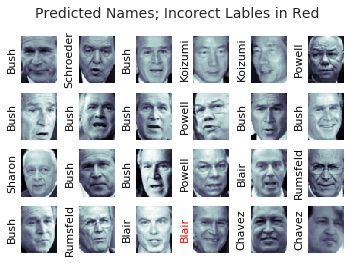

In [29]:
#有了交叉检验的模型，现在就可以对测试集的数据进行预测了
model = grid.best_estimator_
y_fit = model.predict(x_test)
#比较预测结果和真实结果
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(x_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_fit[i]].split()[-1],
                  color='black' if y_fit[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorect Lables in Red', size=14)

In [30]:
#打印分类效果报告，他会列举每个标签的统计结果，从而对评估器的性能有更全面的认识
from sklearn.metrics import classification_report
print(classification_report(y_test, y_fit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



Text(91.68,0.5,'predicted label')

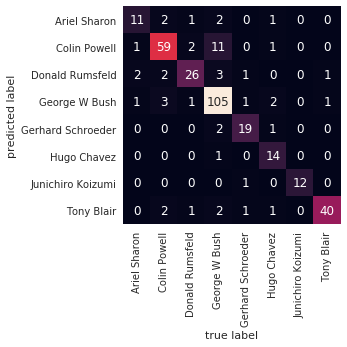

In [31]:
#画出混淆矩阵，它可以帮助我们清晰的判断那些标签容易被分类器误判
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

### 使用RandomizedSearchCV

Text(0.5,0.98,'Predicted Names; Incorect Lables in Red')

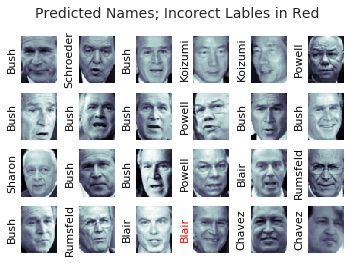

In [32]:
#有了随机搜索的模型，现在就可以对测试集的数据进行预测了
model = rand.best_estimator_
y_fit = model.predict(x_test)
#比较预测结果和真实结果
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(x_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_fit[i]].split()[-1],
                  color='black' if y_fit[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorect Lables in Red', size=14)

In [33]:
#打印分类效果报告，他会列举每个标签的统计结果，从而对评估器的性能有更全面的认识
from sklearn.metrics import classification_report
print(classification_report(y_test, y_fit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.82      0.88      0.85        68
  Donald Rumsfeld       0.76      0.84      0.80        31
    George W Bush       0.97      0.81      0.88       126
Gerhard Schroeder       0.69      0.87      0.77        23
      Hugo Chavez       0.88      0.70      0.78        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.89      0.98      0.93        42

         accuracy                           0.85       337
        macro avg       0.82      0.87      0.83       337
     weighted avg       0.87      0.85      0.86       337



Text(91.68,0.5,'predicted label')

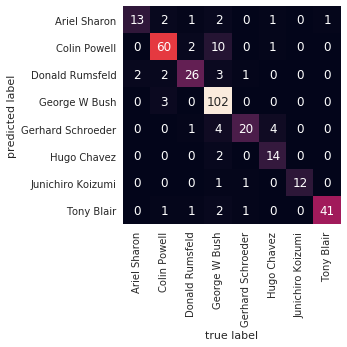

In [34]:
#画出混淆矩阵，它可以帮助我们清晰的判断那些标签容易被分类器误判
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')